In [1]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate

In [2]:
path = "./HW1 Datasets/GTZAN/GTZAN/wav"

genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

annotation_major_scale = ['A', 'A#', 'B', 'C', 'C#','D',
                          'D#', 'E', 'F', 'F#', 'G', 'G#']

annotation_minor_scale = ['a', 'a#', 'b', 'c', 'c#', 'd',
                          'd#', 'e', 'f', 'f#', 'g', 'g#']

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']


In [5]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [6]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [7]:
def find_tonic(path:str, visualize:bool=False):
    # If exist then delete it first
    analysis_path = "./temp/GTZAN_analysis/"
    try:
        shutil.rmtree(analysis_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

    for root, dirs, files in os.walk(path):
        files = sorted(files, key=sort_key_num)
        # print(files)
        for name in files:
            if name.endswith((".wav")):
                # print("============")
                # print("sorted_name", name)
                txt_file_path = name.replace(".wav", ".lerch.txt")
                txt_file_path = txt_file_path.replace("wav", "key")
                # print("txt_file_path = ", txt_file_path)
                genre = txt_file_path.split(".")[0]
                # print("genres", genre)

                binary_file_num_dict[genre] += 1

                y, sr = librosa.load(
                    r"./HW1 Datasets/GTZAN/GTZAN/wav/" + genre + "/" + name)
                # print(y.shape)
                # print(sr)
                
                # -- STFT chromagram
                chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
                
                # -- CQT chromagram
                chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
                
                # -- Chroma Energy Normalized chromagram
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
                # print(chroma_cens.shape)  # 12 dim pitch, 1293 frames
                
                chroma_dict = {"stft":chroma_stft, "cqt":chroma_cqt, "cens":chroma_cens}

                # -- Chromagram visualization -------------------------
                if visualize == True:
                    plt.plot(y)
                    plt.figure(figsize=(15, 15))
                    plt.subplot(3, 1, 1)
                    librosa.display.specshow(chroma_stft, y_axis='chroma')
                    plt.title('chroma_stft')
                    plt.colorbar()
                    plt.subplot(3, 1, 2)
                    librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time')
                    plt.title('chroma_cqt')
                    plt.colorbar()
                    plt.subplot(3, 1, 3)
                    librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
                    plt.title('chroma_cens')
                    plt.colorbar()
                    plt.tight_layout()

                    plt.show()
                # --------------------------------------------------
                
                # -- Save chroma ndarray ------------------------------
                for chroma_operation in chroma_operations:
                    filename = "./temp/GTZAN_analysis/chroma/" + genre + "/" + chroma_operation + "/" + genre + "." + txt_file_path.split(".")[1] + ".chroma_" + chroma_operation + ".txt"
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, 'w') as f:
                        np.savetxt(filename, chroma_dict[chroma_operation])
                # --------------------------------------------------

                # -- Compute x = 1/N sigma(i=1, N){Zi}
                # -- Find tonic pitch
                for chroma_operation in chroma_operations:
                    # chroma_operations = ['stft', 'cqt', 'cens']
                    avg_chromagram = []
                    frame_n = chroma_dict[chroma_operation].shape[1]
                    for pitchs in range(chroma_dict[chroma_operation].shape[0]):
                        accumulate_value = 0
                        for frames in range(chroma_dict[chroma_operation].shape[1]):
                            accumulate_value += chroma_dict[chroma_operation][pitchs][frames]
                        avg_chromagram.append(accumulate_value/frame_n)

                    # print(avg_chromagram)
                    # print("avg_chromagram", len(avg_chromagram))
                    tonic_pitch = (np.argmax(avg_chromagram) + 3) % 12
                    #print("tonic_pitch: ", octave_scale[tonic_pitch])
                    tonic_filename = "./temp/GTZAN_analysis/tonic/" + genre + "_" + chroma_operation + ".txt"
                    os.makedirs(os.path.dirname(tonic_filename), exist_ok=True)
                    with open(tonic_filename, 'a') as f:
                        f.write(str(tonic_pitch) + '\n')
    return

In [8]:
find_tonic(path, False)

In [9]:
def get_chroma(genre:str, chroma_operation:str, index:int):
    chroma_file = "./temp/GTZAN_analysis/chroma/" + genre + "/" + chroma_operation + "/" + genre + "." + str(index).zfill(5) + ".chroma_" + chroma_operation + ".txt"
    with open(chroma_file, 'r') as f:
        return np.loadtxt(chroma_file)

def get_tonic_pitch(genres:list, chroma_operations:list):
    tonic_dict = {}
    for genre in genres:
        genre_tonic_file = "./temp/GTZAN_analysis/tonic/"
        tonic_dict[genre] = {}
        for chroma_operation in chroma_operations:
            filename = genre_tonic_file + genre + "_" + chroma_operation + ".txt"
    
            with open(filename, 'r') as f:
                tonic_dict[genre][chroma_operation] = []
                
                for i in range(100):
                    tonic_dict[genre][chroma_operation].append(int(f.readline().rstrip()))
    return tonic_dict

In [10]:
a = get_chroma("blues", "cqt", 5)

In [11]:
tonic_pitches_dict = get_tonic_pitch(genres_list, chroma_operations)
tonic_pitches_dict['blues']['cqt'][5]

5

In [12]:
def predict_global_key(chroma, major_template, minor_template, tonic_pitch: int):
    # compute x = 1/N sigma(i=1, N){Zi}
    avg_chromagram = []
    frame_n = chroma.shape[1]
    for pitches in range(chroma.shape[0]):
        accumulate_value = 0
        for frames in range(chroma.shape[1]):
            accumulate_value += chroma[pitches][frames]
        avg_chromagram.append(accumulate_value/frame_n)

    # Just compare with tonic pitch's Major and minor chromagram
    major_corelation_coefficient = stats.pearsonr(avg_chromagram, np.roll(major_template, -3 + tonic_pitch))[0]
    minor_corelation_coefficient = stats.pearsonr(avg_chromagram, np.roll(minor_template, -3 + tonic_pitch))[0]

    if major_corelation_coefficient > minor_corelation_coefficient:
        # Major
        return tonic_pitch
    else:
        # minor
        return tonic_pitch+12

def predict(genres_list:list, chroma_operations:list, tonic_pitches_dict:dict):
    predict_path = "./temp/GTZAN_analysis/predict/"
    for genre in genres_list:
        predict_genres_path = predict_path + "/" + genre + "/"
        for chroma_operation in chroma_operations:
            predict_genres_chroma_path = predict_genres_path + "/" + chroma_operation + "/"
            for template_type in template_types:
                filename = predict_genres_chroma_path + template_type + ".txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    for i in range(100):
                        predict_key = predict_global_key(
                                        get_chroma(genre, chroma_operation, i),
                                        templates[template_type][0],
                                        templates[template_type][1],
                                        tonic_pitches_dict[genre][chroma_operation][i]
                                    )
                        f.write(str(predict_key) + '\n')
    return

In [13]:
a_test = predict_global_key(get_chroma('blues', 'cqt', 5), binary_templates[0], binary_templates[1], tonic_pitches_dict['blues']['cqt'][0])
print(a_test)

predict(genres_list, chroma_operations, tonic_pitches_dict)

10


In [14]:
def raw_accuracy(predictions, ground_truth):
    score = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return round(score / len(ground_truth), 5)

def weighted_accuracy(predictions, ground_truth):
    score = 0
    weighted_fifth_count = 0
    weighted_relative_count = 0
    weighted_parallel_count = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
        elif (predictions[i] + 7) % 12 == ground_truth[i]:
            score += 0.5 # perfect fifth
            weighted_fifth_count += 1
        elif predictions[i] < 12:
            if predictions[i] + 9 == ground_truth[i]:
                score += 0.3 # relative Major
                weighted_relative_count += 1
            elif predictions[i] + 12 == ground_truth[i]:
                score += 0.2 # parallel Major
                weighted_parallel_count += 1
        elif predictions[i] >= 12:
            if (predictions[i] + 3) % 12 == ground_truth[i]:
                score += 0.3 # relative minor
                weighted_relative_count += 1
            elif predictions[i] - 12 == ground_truth[i]:
                score += 0.2 # parallel minor
                weighted_parallel_count += 1
    #print("ground_truth:", ground_truth, " [weight]", weighted_fifth_count, weighted_relative_count, weighted_parallel_count)
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return [score / len(ground_truth), weighted_fifth_count, weighted_relative_count, weighted_parallel_count]


def calculate_accuracy(genres_list:list, chroma_operations:list):
    predict_path = "./temp/GTZAN_analysis/predict/"
    label_path = "./HW1 Datasets/GTZAN/GTZAN/key/"
    weighted_distribution = {}
    accuracy = {}
    for genre in genres_list:
        predict_genres_path = predict_path + "/" + genre + "/"
        label_genres_path = label_path + "/" + genre + "/"
        
        accuracy[genre] = {}
        weighted_distribution[genre] = {}
        
        # Ground truth
        ground_truth = []
        for i in range(100):
            label_filename = label_genres_path + genre + '.' + str(i).zfill(5) + ".lerch.txt"
            with open(label_filename, 'r') as f:
                ground_truth.append(int(f.readline().rstrip()))
        
        for chroma_operation in chroma_operations:
            accuracy[genre][chroma_operation] = {}
            weighted_distribution[genre][chroma_operation] = {}
            predict_genres_chroma_path = predict_genres_path + "/" + chroma_operation + "/"

            # Accuracy
            for template_type in template_types:
                accuracy[genre][chroma_operation][template_type] = {}
                weighted_distribution[genre][chroma_operation][template_type] = {}
                predict_filename = predict_genres_chroma_path + template_type + ".txt"
                predictions = []
                with open(predict_filename, 'r') as f:
                    for i in range(100):
                        predictions.append(int(f.readline().rstrip()))
                
                # Raw and weighted acc
                accuracy[genre][chroma_operation][template_type]["raw"] = raw_accuracy(predictions, ground_truth)
                weighted_and_count_list = weighted_accuracy(predictions, ground_truth)
                accuracy[genre][chroma_operation][template_type]["weighted"] = weighted_and_count_list[0]
                weighted_distribution[genre][chroma_operation][template_type]["fifth"] = weighted_and_count_list[1]
                weighted_distribution[genre][chroma_operation][template_type]["relative"] = weighted_and_count_list[2]
                weighted_distribution[genre][chroma_operation][template_type]["parallel"] = weighted_and_count_list[3]

    return accuracy, weighted_distribution

In [15]:
prediction, weighted_distribution = calculate_accuracy(genres_list, chroma_operations)
print(prediction)

{'disco': {'stft': {'binary': {'raw': 0.34, 'weighted': 0.364}, 'ks': {'raw': 0.32, 'weighted': 0.348}, 'harmonic': {'raw': 0.37, 'weighted': 0.3880000000000001}}, 'cqt': {'binary': {'raw': 0.4, 'weighted': 0.425}, 'ks': {'raw': 0.36, 'weighted': 0.39299999999999996}, 'harmonic': {'raw': 0.39, 'weighted': 0.41700000000000004}}, 'cens': {'binary': {'raw': 0.35, 'weighted': 0.379}, 'ks': {'raw': 0.32, 'weighted': 0.355}, 'harmonic': {'raw': 0.36, 'weighted': 0.387}}}, 'reggae': {'stft': {'binary': {'raw': 0.42, 'weighted': 0.43}, 'ks': {'raw': 0.41, 'weighted': 0.42200000000000004}, 'harmonic': {'raw': 0.41, 'weighted': 0.42200000000000004}}, 'cqt': {'binary': {'raw': 0.32, 'weighted': 0.3459999999999999}, 'ks': {'raw': 0.38, 'weighted': 0.39399999999999996}, 'harmonic': {'raw': 0.41, 'weighted': 0.418}}, 'cens': {'binary': {'raw': 0.31, 'weighted': 0.33699999999999997}, 'ks': {'raw': 0.37, 'weighted': 0.385}, 'harmonic': {'raw': 0.36, 'weighted': 0.377}}}, 'pop': {'stft': {'binary': {'r

## 預測結果視覺化
將 dictionary 轉為 dataframe 可以有助於進行視覺化。

In [20]:
columns = ['genre', 'chroma_operation','template_type', 'acc_type']
prediction_df = pd.DataFrame.from_dict({(i, j, k): prediction[i][j][k] 
                            for i in prediction.keys() 
                            for j in prediction[i].keys()
                            for k in prediction[i][j].keys()
                            }, orient='columns').T

prediction_df.reset_index(inplace=True)
prediction_df.columns = ['genre', 'chroma_operation','template_type', 'raw', 'weight']
print(prediction_df)
print(tabulate(prediction_df, headers='keys', tablefmt='fancy_grid'))

      genre chroma_operation template_type   raw  weight
0     disco             stft        binary  0.34   0.364
1     disco             stft            ks  0.32   0.348
2     disco             stft      harmonic  0.37   0.388
3     disco              cqt        binary  0.40   0.425
4     disco              cqt            ks  0.36   0.393
..      ...              ...           ...   ...     ...
76  country              cqt            ks  0.51   0.534
77  country              cqt      harmonic  0.45   0.486
78  country             cens        binary  0.48   0.501
79  country             cens            ks  0.48   0.501
80  country             cens      harmonic  0.46   0.485

[81 rows x 5 columns]
╒════╤═════════╤════════════════════╤═════════════════╤═══════╤══════════╕
│    │ genre   │ chroma_operation   │ template_type   │   raw │   weight │
╞════╪═════════╪════════════════════╪═════════════════╪═══════╪══════════╡
│  0 │ disco   │ stft               │ binary          │  0.34 │    0

## 加權分數的計算
關係調，平行調之間的關係是：「大調找小調，小調找大調」的關係。

● 關係調定義為(大調找關係小調減三個半音，小調找關係大調加三個半音)：音階主音不同，但音階組成的音完全一樣。ex: GMaj <-> Emin, CMaj <-> Amin。<br/>
● 平行調定義為：音階主音相同，但音階組成的音不一樣。ex:GMaj <-> Gmin, CMaj <-> Cmin。<br/>
● 完全五度：差五個半音 C 的高五度音為 G，G 的高五度音為 D，以此類推。<br/>

作業指定作法為先計算出可能的主音，再計算當前 chromagram 與預測主音大小調間的 pearson correlation coefficient，兩者擇一。
下圖可以看出加權後分數較高一些，而受到加權而加分的三種類別：完全五度、關係調及平行調。

<AxesSubplot:>

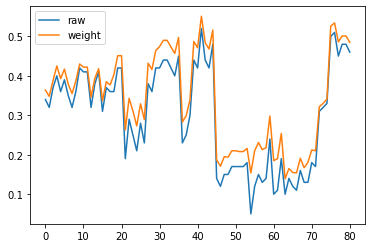

In [21]:
# Raw vs. weighted
prediction_df.plot()

## 加權分佈
從以下的加權分佈可以看到誤判為平行調的佔絕大多數。可能代表以最多出現次數的音視為主音的想法有一定的可靠度，但是每首樂曲可能因為時長不足，抑或曲風特性所致——爵士、藍調容易出現和弦外音可能剛巧反而符合相反大小調的音階分佈。

而判斷為完全五度及關係調的原因，可能是主音原本就找錯了（在以出現最多次的音作為主音的規則下），導致最後的結果出錯。
但全部大小調都比對一次或許也太過耗時，兩種作法間需做權衡。

In [22]:
columns = ['genre', 'chroma_operation','template_type', 'acc_type']
weighted_distribution_df = pd.DataFrame.from_dict({(i, j, k): weighted_distribution[i][j][k] 
                            for i in weighted_distribution.keys() 
                            for j in weighted_distribution[i].keys()
                            for k in weighted_distribution[i][j].keys()
                            }, orient='columns').T

weighted_distribution_df.reset_index(inplace=True)
weighted_distribution_df.columns = ['genre', 'chroma_operation','template_type', 'weighted_count_fifth', 'weighted_count_relative', 'weighted_count_parallel']

print(tabulate(weighted_distribution_df, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════╤════════════════════╤═════════════════╤════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│    │ genre   │ chroma_operation   │ template_type   │   weighted_count_fifth │   weighted_count_relative │   weighted_count_parallel │
╞════╪═════════╪════════════════════╪═════════════════╪════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│  0 │ disco   │ stft               │ binary          │                      1 │                         1 │                         8 │
├────┼─────────┼────────────────────┼─────────────────┼────────────────────────┼───────────────────────────┼───────────────────────────┤
│  1 │ disco   │ stft               │ ks              │                      1 │                         1 │                        10 │
├────┼─────────┼────────────────────┼─────────────────┼────────────────────────┼───────────────────────────┼───────────────────────────┤
│  2 │ disco   │ stft               │ har

<AxesSubplot:>

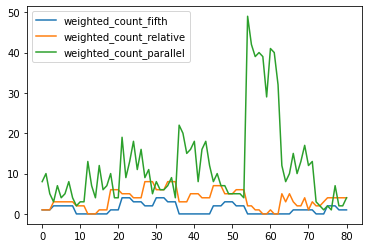

In [23]:
weighted_distribution_df.plot()

## 不同曲風
所得到的分數也會受不同曲風所影響，從下圖可以看出，在各個曲風中得分最低的三個類別為藍調(blues)、饒舌(hip-hop)和爵士(jazz)，而得分最高的則是：鄉村(country)、搖滾(rock)和金屬(metal)。
或許從曲風的特色可以窺知一二。<br/>
藍調和爵士常大量使用和弦外音及裝飾音進行旋律上的變化，創造聽覺上情感的豐富度，且即興和轉調的情況也較常見，因此使用出現最多次的音符作為主音的這個方法較不適用於這些曲風上。而嘻哈饒舌中大量的 rap 片段，這些「說話」的部份一樣會有音高，但這些說話部份不太能作為「旋律」來進行分析，就像是我們不太會將一場演講來進行音高成份分析是一樣的道理，這時候去掉人聲對背景音樂進行 chromagram 分析或許才能提高分數。

鄉村樂曲源於美國民謠曲風，結合民歌、宗教福音和藍調，是為專於營造流暢且以流行音樂為導向的風格。民謠(folk)這種曲風的特色就是容易讓人琅琅上口，容易讓第一次聽到的人也可以接受並哼唱出來，旋律大致不會進行太多的不和諧變化，在歌曲中也常會使用反覆來加深聽者的印象，曲調上會聽起來較舒服、放鬆，這樣的感受就是因為曲調在一段較長時間中都較穩定。
搖滾結合了藍調音樂、鄉村音樂、爵士樂還有古典音樂等特色，可謂曲風的集大成，具有 4/4 簡單節奏及簡單樂句的大量重複為其特點，相較於鄉村加入了更多的電子樂器。而金屬為搖滾的衍生，金屬音樂特點為高度失真的電吉他、加長吉他獨奏及密集快速的鼓點，創造音量大、爆發力大且節拍快速的歌曲風格，歌詞描寫更加 gangsta，這些變化可以說都是音色和音效上的差別，而不會改變其使用的音階調式，比起爵士或藍調更加可以被明確歸類其調式。古典音樂的某些創作本身就具有厚重的織體、龐大的結構和規模，跟金屬的本質在織體(texture)上具有很多相似之處。因此這些曲風使用 chromagram 做樂曲的 key detection 就較適合。<br/>




In [24]:
group_by_genre = prediction_df.groupby("genre")
group_by_genre.mean()


,raw,weight
genre,,
blues,0.136667,0.217000
country,0.426667,0.447333
disco,0.356667,0.384000
hiphop,0.137778,0.174889
jazz,0.157778,0.199889
metal,0.388889,0.433111
pop,0.294444,0.345889
reggae,0.376667,0.392333
rock,0.414444,0.465889


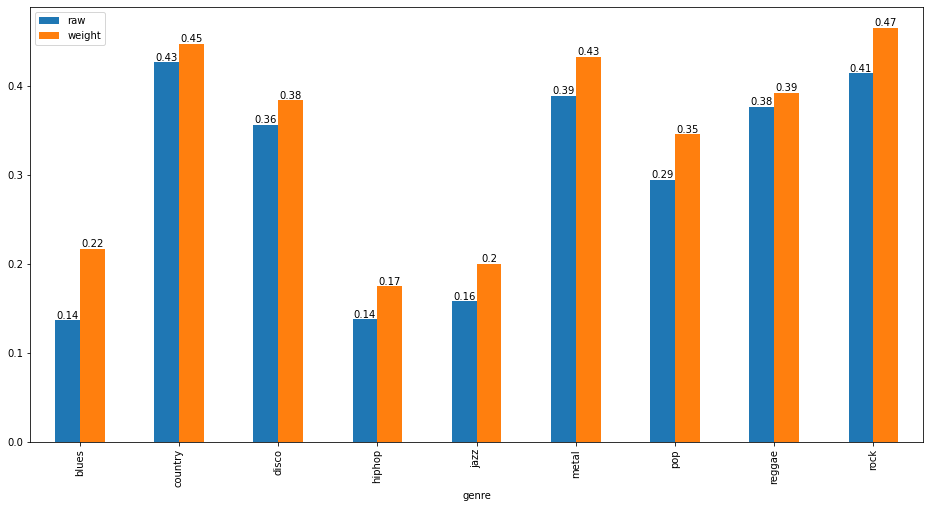

In [25]:
group_by_genre_mean = group_by_genre.mean()

ax = group_by_genre_mean.plot(kind='bar', figsize=(16, 8))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

## 不同 template 形式
使用三種 template 建立方式來進行 24 種大小調的理想 chromagram template 分佈狀態， binary, ks 以及 harmonic template。<br/>
一個八度中採用 12 平均律可分為 12 個音高： C, C#, D, D#, E, F, F#, G, G#, A, A#, B<br/>

### Binary
理想情況下，同一曲調中出現的音將會呈現固定的音階形式，而大調和小調為其中兩種形式。<br/>
binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]<br/>
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]<br/>

### K-S
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]<br/>
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]<br/>

### Harmonic
首先計算出 C ~ B 中 12 個音的泛音列，使用以下公式計算：<br/>
U<sub>C</sub> = [1 + α + α<sup>3</sup> + α<sup>7</sup>, 0, 0, 0, α<sup>4</sup>, 0, 0, α<sup>2</sup> + α<sup>5</sup>, 0, 0, α<sup>6</sup>, 0]<br/>
U<sub>C#</sub> = [0, 1 + α + α<sup>3</sup> + α<sup>7</sup>, 0, 0, 0, α<sup>4</sup>, 0, 0, α<sup>2</sup> + α<sup>5</sup>, 0, 0, α<sup>6</sup>] ，如此向右進行 circular shift 以此類推。<br/>
之後再根據 binary template 進行泛音列加總：<br/>
C<sub>Major</sub> = U<sub>C</sub> + U<sub>D</sub> + U<sub>E</sub> + U<sub>F</sub> + U<sub>G</sub> + U<sub>A</sub> + U<sub>B</sub><br/>
C<sub>minor</sub> = U<sub>C#</sub> + U<sub>D#</sub> + U<sub>E</sub> + U<sub>F#</sub> + U<sub>G#</sub> + U<sub>A#</sub> + U<sub>B#</sub> ，以此類推

從下圖可以看出 harmonic template 可以得到三者中最好的表現。

In [26]:
group_by_template_type = prediction_df.groupby("template_type")
group_by_template_type.mean()

,raw,weight
template_type,,
binary,0.281481,0.326556
harmonic,0.316667,0.354259
ks,0.298519,0.339296


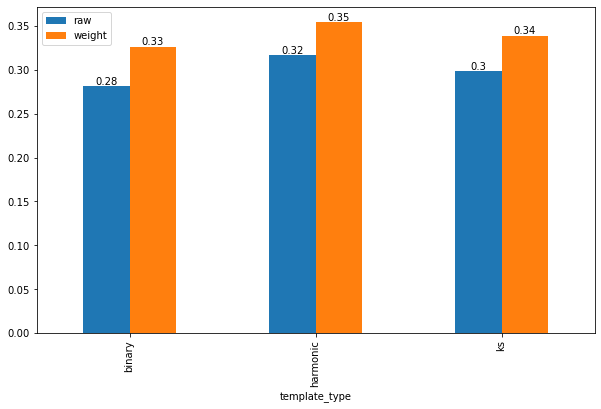

In [27]:
group_by_template_type_mean = group_by_template_type.mean()

ax = group_by_template_type_mean.plot(kind='bar', figsize=(10, 6))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

## 不同 spectrogram 擷取方法
透過不同的時頻圖轉換方式，STFT、CQT 及 CENS 獲得 spectrogram 後再轉換為 chromagram。

● STFT：先將輸入訊號分成多個很短的固定時間區塊，透過 window function 的運算，取得 local time window 作瞬時的頻譜近似，每一個時間點都透過傅立葉轉換得到其對應的頻譜。
在此作業使用 window length = 4096 ，是因為 window 長度越能分辨精確的頻率。但當要處理的頻率域範圍非常廣，有些音比較長有些音比較短，很難把每個<br/>
● CQT：如果同一時間有很高音跟很低音同時出現， 但 window 較大適合處理低音，較小適合處理高音，無法兩全其美。使用 CQT 的目標在於對於不同頻帶都要做頻譜分析，每個 moment 都取不同長度的 window 作傅立葉轉換，雖然較麻煩但也較能處理同時出現的高低音分析。採用 log frequency scale，依照 12 平均律在一個八度內取 12 個 scale 。<br/>
● CENS(Chroma Energy Normalized)：CENS 的主要目標是在較長的 window 範圍上進行統計，可以平滑化節奏、發聲和音樂中的裝飾音（ex:顫音和琶音）所造成的局部偏差。chromagram 上可以看出比以上兩者更平滑。<br/>

在下圖中可以看出 CQT 在此資料集上的效果最好，其次是 CENS。

In [28]:
group_by_chroma_operation = prediction_df.groupby("chroma_operation")
group_by_chroma_operation.mean()

,raw,weight
chroma_operation,,
cens,0.304444,0.346556
cqt,0.315926,0.358296
stft,0.276296,0.315259


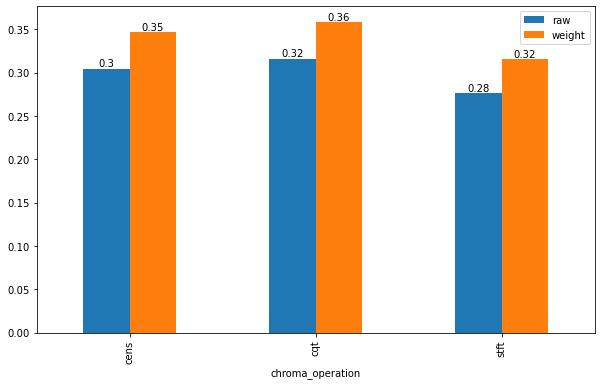

In [29]:
group_by_chroma_operation_mean = group_by_chroma_operation.mean()

ax = group_by_chroma_operation_mean.plot(kind='bar', figsize=(10, 6))
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')